# Smart Water Management (Function 1) — Udawalawe Hydrological Data (1994–2025)

This notebook supports **Function 1: IoT-Enabled ML-Driven Smart Water Management** in the integrated irrigation system.

### Goal
- Use historical **reservoir + canal release + rainfall/inflow** signals to train an ML model that predicts **next-day irrigation release need** (proxy: `Main Canals: LB+RB (MCM)`).
- Convert the predicted value into a **control decision** (e.g., open/close valve / release recommendation).

### Why this matches Function 1
Your proposal and Topic Assessment Form describe a pipeline where sensors stream data, an ML model estimates irrigation demand, and actuators (valves/pumps) respond automatically, with dashboard override.


In [1]:
# If running in a fresh environment, install dependencies if needed:
# !pip install pandas openpyxl scikit-learn matplotlib joblib

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import joblib

DATA_PATH = "01. Hydrological Data 1994 to 2025.xlsx"  # Excel file should be in the same folder as this notebook

## 1. Load + normalize the multi-sheet (yearly) Excel structure
Each year sheet has a couple of title rows; we auto-detect the row that contains **'Date'** and treat that as the header.

In [2]:
def parse_year_sheet(xl: pd.ExcelFile, sheet_name: str) -> pd.DataFrame:
    raw = xl.parse(sheet_name, header=None)
    header_row = None
    for i in range(min(40, len(raw))):
        v = raw.iloc[i, 0]
        if isinstance(v, str) and v.strip().lower() == "date":
            header_row = i
            break
        if str(v).strip().lower() == "date":
            header_row = i
            break
    if header_row is None:
        return pd.DataFrame()

    header = raw.iloc[header_row].tolist()
    df = raw.iloc[header_row + 1:].copy()
    df.columns = header
    df = df.dropna(how="all")

    # Clean column names: drop NaN/blank names later
    df.columns = [str(c).strip() if c == c else "" for c in df.columns]
    df = df.loc[:, [c for c in df.columns if c and c.lower() != "nan"]]

    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df[df["Date"].notna()].copy()
    df["YearSheet"] = sheet_name
    return df

def to_numeric(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.number)):
        return float(x)
    s = str(x).strip()
    if s == "" or s.lower() == "nan":
        return np.nan
    s = s.replace(",", "")
    # keep digits, dot, minus, exponent
    s = re.sub(r"[^0-9.\-+eE]", "", s)
    try:
        return float(s)
    except:
        return np.nan

xl = pd.ExcelFile(DATA_PATH)
year_sheets = [s for s in xl.sheet_names if re.fullmatch(r"\d{4}", str(s))]
print("Year sheets:", len(year_sheets), year_sheets[:5], "...", year_sheets[-5:])

dfs = []
for y in year_sheets:
    d = parse_year_sheet(xl, y)
    if not d.empty:
        dfs.append(d)

data = pd.concat(dfs, ignore_index=True)
print("Combined rows:", data.shape)
print("Date range:", data["Date"].min(), "→", data["Date"].max())


Year sheets: 32 ['1994', '1995', '1996', '1997', '1998'] ... ['2021', '2022', '2023', '2024', '2025']
Combined rows: (11687, 21)
Date range: 1994-01-01 00:00:00 → 2025-12-31 00:00:00


## 2. Standardize column names + convert to numeric

In [3]:
rename_map = {
    "Water Level\n(mMSL)": "water_level_mmsl",
    "Water Level\n(ftMSL)": "water_level_ftmsl",
    "Total Storage\n(MCM)": "total_storage_mcm",
    "Active Storage\n(MCM)": "active_storage_mcm",
    "Gross Storage Percentage\n(%)": "gross_storage_pct",
    "Net Percentage\n(%)": "net_storage_pct",
    "Energy\n(MWh)": "energy_mwh",
    "LB Main Canal\n(MCM)": "lb_main_canal_mcm",
    "RB Main Canal\n(MCM)": "rb_main_canal_mcm",
    "Main Canals: LB+RB\n(MCM)": "main_canals_mcm",
    "Spillway\n(MCM)": "spillway_mcm",
    "Evaporation\n(mm)": "evap_mm",
    "Evaporation\n(MCM)": "evap_mcm",
    "Inflow\n(MCM)": "inflow_mcm",
    "Rainfall\n(mm)": "rain_mm",
    "LB By Pass\n(MCM)": "lb_bypass_mcm",
    "RB By Pass \n(MCM)": "rb_bypass_mcm",
    "Average wind speed (m/s)": "wind_speed_ms",
    "Average Wind Speed (m/s)": "wind_speed_ms",
}

data = data.rename(columns=rename_map)

# Convert numeric columns
for c in data.columns:
    if c in ["Date", "YearSheet"]:
        continue
    data[c] = data[c].map(to_numeric)

data = data.sort_values("Date").reset_index(drop=True)

print("Columns:")
print(sorted(data.columns))

missing = data.isna().mean().sort_values(ascending=False)
print("\nMissingness (top 15):")
print(missing.head(15))


Columns:
['Date', 'YearSheet', 'active_storage_mcm', 'energy_mwh', 'evap_mcm', 'evap_mm', 'gross_storage_pct', 'inflow_mcm', 'lb_bypass_mcm', 'lb_main_canal_mcm', 'main_canals_mcm', 'net_storage_pct', 'rain_mm', 'rb_bypass_mcm', 'rb_main_canal_mcm', 'spillway_mcm', 'total_storage_mcm', 'water_level_ftmsl', 'water_level_mmsl', 'wind_speed_ms', 'wind_speed_ms']

Missingness (top 15):
wind_speed_ms         0.968769
wind_speed_ms         0.888081
rb_bypass_mcm         0.839651
lb_bypass_mcm         0.839651
evap_mcm              0.706084
evap_mm               0.705314
energy_mwh            0.497989
spillway_mcm          0.450415
rb_main_canal_mcm     0.076410
lb_main_canal_mcm     0.076324
active_storage_mcm    0.064259
net_storage_pct       0.064259
total_storage_mcm     0.064259
gross_storage_pct     0.064259
main_canals_mcm       0.063489
dtype: float64


## 3. Basic EDA (plots)
You can adjust the plots depending on what you want to highlight in your report.

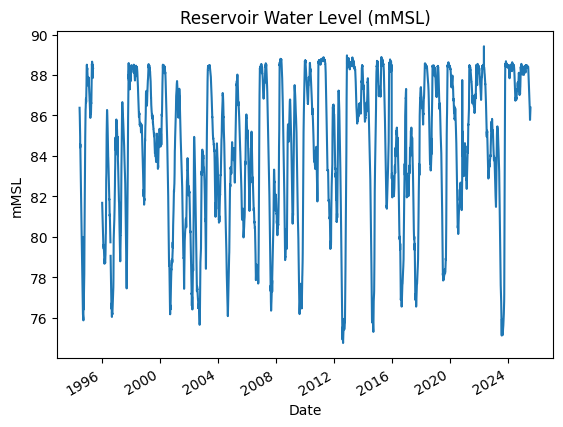

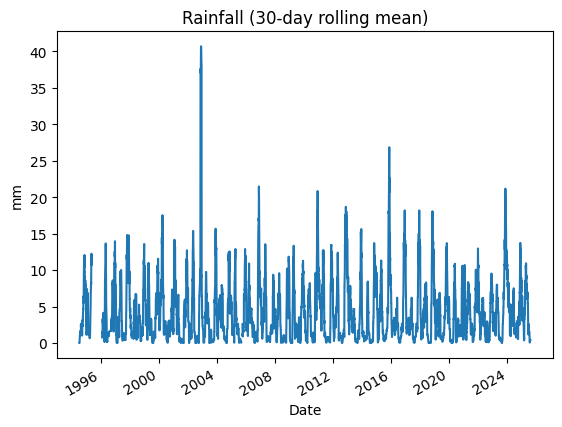

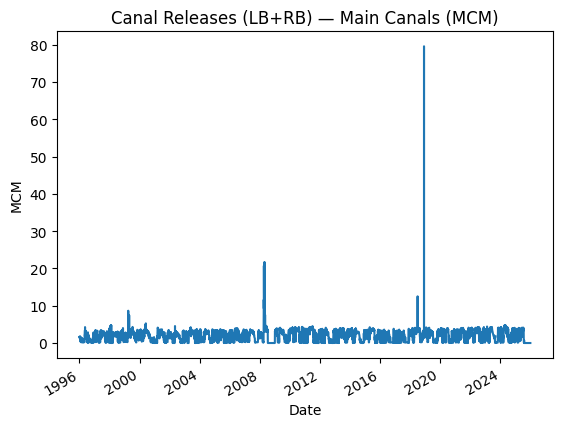

In [4]:
plt.figure()
data.set_index("Date")["water_level_mmsl"].plot(title="Reservoir Water Level (mMSL)")
plt.xlabel("Date")
plt.ylabel("mMSL")
plt.show()

plt.figure()
data.set_index("Date")["rain_mm"].rolling(30).mean().plot(title="Rainfall (30-day rolling mean)")
plt.xlabel("Date")
plt.ylabel("mm")
plt.show()

if "main_canals_mcm" in data.columns:
    plt.figure()
    data.set_index("Date")["main_canals_mcm"].plot(title="Canal Releases (LB+RB) — Main Canals (MCM)")
    plt.xlabel("Date")
    plt.ylabel("MCM")
    plt.show()


## 4. Feature engineering for ML
We model **next-day canal release** as a proxy for irrigation demand.

Target:
- `target_main_canals_nextday = main_canals_mcm(t+1)`

Features:
- current day reservoir + hydro-meteorological signals
- lag features (1/2/3/7 days)
- rolling means (3/7/14 days)
- calendar features (month, day-of-week)


In [5]:
required_cols = [
    "water_level_mmsl",
    "total_storage_mcm",
    "active_storage_mcm",
    "inflow_mcm",
    "rain_mm",
    "lb_main_canal_mcm",
    "rb_main_canal_mcm",
    "main_canals_mcm",
]
optional_cols = ["spillway_mcm", "evap_mm", "wind_speed_ms"]

use_cols = [c for c in required_cols if c in data.columns]
use_cols += [c for c in optional_cols if c in data.columns]

df = data[["Date"] + use_cols].copy()

# Lags
lag_cols = ["water_level_mmsl", "total_storage_mcm", "inflow_mcm", "rain_mm", "main_canals_mcm"]
lag_cols = [c for c in lag_cols if c in df.columns]

for lag in [1, 2, 3, 7]:
    for c in lag_cols:
        df[f"{c}_lag{lag}"] = df[c].shift(lag)

# Rolling means
for win in [3, 7, 14]:
    if "rain_mm" in df.columns:
        df[f"rain_mm_roll{win}"] = df["rain_mm"].rolling(win).mean()
    if "inflow_mcm" in df.columns:
        df[f"inflow_mcm_roll{win}"] = df["inflow_mcm"].rolling(win).mean()
    if "water_level_mmsl" in df.columns:
        df[f"water_level_mmsl_roll{win}"] = df["water_level_mmsl"].rolling(win).mean()

# Target (next day)
df["target_main_canals_nextday"] = df["main_canals_mcm"].shift(-1)

# Calendar features
df["month"] = df["Date"].dt.month
df["dow"] = df["Date"].dt.dayofweek
df["dayofyear"] = df["Date"].dt.dayofyear

df_model = df.dropna(subset=["target_main_canals_nextday"]).copy()
print("Model rows:", df_model.shape)


Model rows: (10945, 46)


## 5. Train / Test split (time-based)
We use a clean time split to avoid leakage. Adjust the cutoff based on your report needs.

In [6]:
cutoff = pd.Timestamp("2023-01-01")
train = df_model[df_model["Date"] < cutoff].copy()
test  = df_model[df_model["Date"] >= cutoff].copy()

feature_cols = [c for c in df_model.columns if c not in ["Date", "target_main_canals_nextday"]]
X_train, y_train = train[feature_cols], train["target_main_canals_nextday"]
X_test, y_test   = test[feature_cols],  test["target_main_canals_nextday"]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train range:", train["Date"].min(), "→", train["Date"].max())
print("Test range:", test["Date"].min(), "→", test["Date"].max())


Train: (9850, 46) Test: (1095, 46)
Train range: 1995-12-31 00:00:00 → 2022-12-31 00:00:00
Test range: 2023-01-01 00:00:00 → 2025-12-30 00:00:00


## 6. Train ML models
These align with your proposal’s suggested model families (regression + tree/ensemble).
- **Ridge** (fast baseline)
- **Random Forest** (nonlinear)
- **HistGradientBoosting** (strong tabular model)


In [7]:
def evaluate(model, X, y, label=""):
    pred = model.predict(X)
    mae = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))
    r2 = r2_score(y, pred)
    print(f"{label} MAE={mae:.4f}  RMSE={rmse:.4f}  R2={r2:.4f}")
    return pred

ridge = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

# Keep RF modest so it runs quickly
rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=120,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=2
    ))
])

hgb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        random_state=42,
        max_depth=6,
        learning_rate=0.07,
        max_iter=250
    ))
])

for m in [ridge, rf, hgb]:
    m.fit(X_train, y_train)

print("=== Test metrics ===")
evaluate(ridge, X_test, y_test, "Ridge")
evaluate(rf, X_test, y_test, "RandomForest")
evaluate(hgb, X_test, y_test, "HistGB")

=== Test metrics ===
Ridge MAE=0.5191  RMSE=0.7497  R2=0.7718
RandomForest MAE=0.4366  RMSE=0.8514  R2=0.7058
HistGB MAE=0.4412  RMSE=0.7108  R2=0.7949


array([3.24891094, 3.10347657, 3.21927134, ..., 0.34989668, 0.3531519 ,
       0.3531519 ], shape=(1095,))

## 7. Pick a best model + export
Switch `best_model = ...` based on your evaluation metrics.

This saved model is what you later serve inside your IoT pipeline (edge/cloud) to produce predictions in near real-time.

In [8]:
best_model = hgb  # change if RF performs better

MODEL_OUT = "smart_water_mgmt_release_predictor.joblib"
joblib.dump(best_model, MODEL_OUT)
print("Saved:", MODEL_OUT)


Saved: smart_water_mgmt_release_predictor.joblib


## 8. Convert prediction → irrigation control decision
This is the bridge from ML → actuator control.

Example rule (edit to match your field constraints):
- If predicted next-day release is **> threshold** AND reservoir level is above **minimum safe level**, then recommend **OPEN/ON**.
- Otherwise recommend **CLOSE/OFF**.


In [9]:
def decide_actuation(pred_release_mcm: float, reservoir_level_mmsl: float,
                     release_threshold_mcm: float = 0.5,
                     min_safe_level_mmsl: float = 80.0):
    """Return a simple control decision for an actuator."""
    if np.isnan(pred_release_mcm) or np.isnan(reservoir_level_mmsl):
        return {"action": "HOLD", "reason": "missing inputs"}

    if (pred_release_mcm > release_threshold_mcm) and (reservoir_level_mmsl >= min_safe_level_mmsl):
        return {"action": "OPEN/ON", "reason": "demand predicted + safe reservoir level"}
    return {"action": "CLOSE/OFF", "reason": "low demand OR reservoir too low"}

# Example on the most recent row in df_model
latest = df_model.sort_values("Date").iloc[-1]
x_latest = latest[feature_cols].to_frame().T
pred_next = best_model.predict(x_latest)[0]

decision = decide_actuation(pred_next, latest.get("water_level_mmsl", np.nan))
print("Date:", latest["Date"])
print("Pred next-day release (MCM):", pred_next)
print("Decision:", decision)


Date: 2025-12-30 00:00:00
Pred next-day release (MCM): 0.3531519010317297
Decision: {'action': 'HOLD', 'reason': 'missing inputs'}


## 9. Next integration step (your system)
- Replace/augment this dataset with **IoT field sensors** (soil moisture, temp/humidity, local rainfall) + canal/reservoir feeds.
- Serve the model via a small API (FastAPI) and send decisions to your actuator controller through MQTT.
- Log predictions + actual outcomes for retraining / drift detection.
